In [803]:
import os
import pandas as pd
import openpyxl
import ast
from itertools import product
import matplotlib.pyplot as plt
import networkx as nx
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

## 데이터 불러오기

In [804]:
DATA_DIR = "../data/"
files = [file_name for file_name in os.listdir(DATA_DIR) if file_name[-5:] == '.xlsx']

transaction_data = []

for i in sorted(files):
  transaction_data.append(pd.read_excel(os.path.join(DATA_DIR, i), sheet_name=1))

## Transaction data - pairs

### total ipc

In [805]:
df = pd.read_excel(os.path.join(DATA_DIR, i), sheet_name=0)
total_ipc = pd.DataFrame(df["ipc"].tolist(), columns=["ipc"])
total_ipc

,ipc
0,G09B
1,G09C
2,H01P
3,H01Q
4,H01S
5,H02J
6,H03B
7,H03C
8,H03D
9,H03F


### 각 노드당 neighborhoods 탐색

In [806]:
## neighborhoods: 해당 노드와 같은 p_id로 연결되어 있는 노드
def neighborhoods(total_ipc_df, trans, node):
  p_id = trans.loc[trans["ori_ipc"] == node, "p_id"].values
  neighborhoods = trans.loc[trans["p_id"].isin(p_id), "ori_ipc"].values
  neighborhoods = [i for i in neighborhoods if i != node]
  neighborhoods = list(set(neighborhoods))
  neighborhoods = str(neighborhoods)
  total_ipc_df.loc[total_ipc_df["ipc"] == node, "neighborhoods"] = neighborhoods
  return total_ipc_df

## 모든 period transaction_data에 neighborhoods 생성
total_ipc["neighborhoods"] = ""
p1_trans = transaction_data[0]; p2_trans = transaction_data[1]; p3_trans = transaction_data[2]
p1_neighbor = total_ipc.copy(); p2_neighbor = total_ipc.copy(); p3_neighbor = total_ipc.copy(); 

for ipc in total_ipc["ipc"].values:
  p1_neighbor = neighborhoods(p1_neighbor, p1_trans, ipc)
  p2_neighbor = neighborhoods(p2_neighbor, p2_trans, ipc)
  p3_neighbor = neighborhoods(p3_neighbor, p3_trans, ipc)

## 리스트 행으로 변환
def str_to_list(x: str):
  return ast.literal_eval(x)

p1_neighbor["neighborhoods"] = p1_neighbor["neighborhoods"].apply(str_to_list)
p2_neighbor["neighborhoods"] = p2_neighbor["neighborhoods"].apply(str_to_list)
p3_neighbor["neighborhoods"] = p3_neighbor["neighborhoods"].apply(str_to_list)

p1_neighbor.head(10)

,ipc,neighborhoods
0,G09B,"[G02F, G09G, G06K, A47D, B65D, G06G, A61G, A61..."
1,G09C,"[A44C, G09F, B42F, B42D, H04N, A61B, B65D]"
2,H01P,"[A61N, G02B, G06K, A61B, H05K, H01S]"
3,H01Q,"[A61N, H04B, H04M, A61B, H04W, A61K, G08B]"
4,H01S,"[G01N, G02F, H05H, A61N, B23P, G21G, G21K, B05..."
5,H02J,"[H01M, G01N, A61N, H04Q, H04M, F04B, A61M, G01..."
6,H03B,"[H03G, A61N, H03M, A47B, H04B, H04M, G10K, A61..."
7,H03C,[]
8,H03D,[]
9,H03F,"[G01N, G05D, G01C, H04B, B05B, A61B, A61L, G06..."


## Y label 찾기

### total possible pairs

In [807]:
df = pd.read_excel(os.path.join(DATA_DIR, i), sheet_name=0)
ipc_35 = df[df["tech_group"] == "35 Signal transmission, telecommunications"]["ipc"].tolist()
ipc_37 = df[df["tech_group"] == "37 Medical equipment"]["ipc"].tolist()
all_combination_df = pd.DataFrame(list(product(ipc_35, ipc_37)), columns=["ipc1", "ipc2"])
all_combination_df

,ipc1,ipc2
0,G09B,A61B
1,G09B,A61C
2,G09B,A61D
3,G09B,A61F
4,G09B,A61G
...,...,...
373,H05K,C12M
374,H05K,G01T
375,H05K,G21G
376,H05K,G2IK


### 각 period당 pairs 연결 유무

In [808]:
all_combination_df[["period 1", "period 2", "period 3"]] = 1

## 앞서 구한 neighbor_df에 (ipc1, ipc2) 조합이 존재한다면, 0 그렇지 않을 경우, 1
def get_pairs_per_period(neighbor_df, col_ind):
  for ind, (ipc1, ipc2) in zip(all_combination_df.index, all_combination_df[["ipc1", "ipc2"]].values):
    if ipc2 in neighbor_df.loc[neighbor_df["ipc"] == ipc1, "neighborhoods"].values[0]:
      all_combination_df.iloc[ind, col_ind] = 0
    
## 모든 period에 대해 pair 연결 유무
get_pairs_per_period(p1_neighbor, 2); get_pairs_per_period(p2_neighbor, 3); get_pairs_per_period(p3_neighbor, 4);

all_combination_df

,ipc1,ipc2,period 1,period 2,period 3
0,G09B,A61B,0,0,0
1,G09B,A61C,0,0,0
2,G09B,A61D,0,0,1
3,G09B,A61F,0,0,0
4,G09B,A61G,0,0,0
...,...,...,...,...,...
373,H05K,C12M,1,1,0
374,H05K,G01T,1,0,0
375,H05K,G21G,1,1,1
376,H05K,G2IK,1,1,1


### period 연결 유무에 따른 train_y, test_y 찾기

- period 1 = 1 and period 2 = 0 일 때, `training y = 0`
- period 2 = 1 and period 3 = 0 일 때, `test y = 0`

In [809]:
all_combination_df[["train_y", "test_y"]] = 1

## train, test label 찾기
all_combination_df.loc[(all_combination_df["period 1"] == 1) & (all_combination_df["period 2"] == 0), "train_y"] = 0
all_combination_df.loc[(all_combination_df["period 2"] == 1) & (all_combination_df["period 3"] == 0), "test_y"] = 0

## train_df, test_df
train_df = all_combination_df.loc[all_combination_df["period 1"] == 1, ["ipc1", "ipc2", "train_y"]]
test_df = all_combination_df.loc[all_combination_df["period 2"] == 1, ["ipc1", "ipc2", "test_y"]]

train_df

,ipc1,ipc2,train_y
6,G09B,A61J,0
8,G09B,A61M,0
11,G09B,B01L,1
12,G09B,B04B,1
13,G09B,C12M,1
...,...,...,...
373,H05K,C12M,1
374,H05K,G01T,0
375,H05K,G21G,1
376,H05K,G2IK,1


In [810]:
print(train_df["train_y"].value_counts())
print(test_df["test_y"].value_counts())

1    208
0     99
Name: train_y, dtype: int64
1    168
0     45
Name: test_y, dtype: int64


## Link Prediction method를 활용한 Input Features

### 네트워크 생성

In [811]:
p1_graph = nx.Graph(); p2_graph = nx.Graph();

def make_nodes(neighbor_df):
  nodes = []
  nodes += neighbor_df["ipc"].values.tolist()
  for neighborhood_nodes in neighbor_df["neighborhoods"]:
    nodes += neighborhood_nodes
  nodes = list(set(nodes))
  return nodes

def make_edges(neighbor_df):
  edges = []
  for node, neighborhood_edges in neighbor_df[["ipc", "neighborhoods"]].values:
    edges += list(product([node], neighborhood_edges))
  edges = list(set(edges))
  edges = [(x, y) for x, y in edges if (y, x) not in edges]
  return edges

p1_graph.add_nodes_from(make_nodes(p1_neighbor))
p1_graph.add_edges_from(make_edges(p1_neighbor))
p2_graph.add_nodes_from(make_nodes(p2_neighbor))
p2_graph.add_edges_from(make_edges(p2_neighbor))

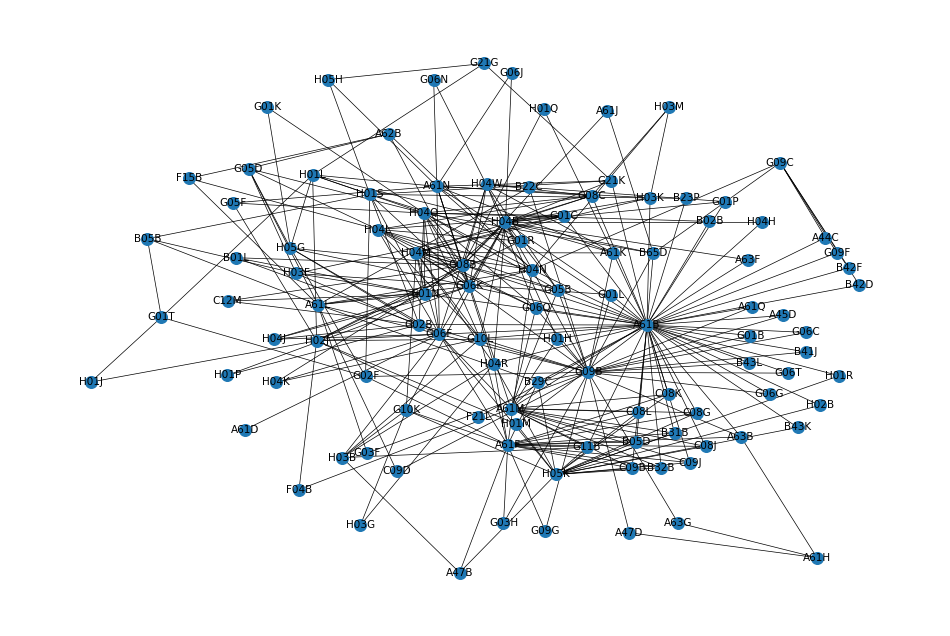

In [835]:
def draw_graph(Graph):
  connected_components = list(nx.connected_components(Graph))
  largest_component = max(connected_components, key=len)
  G_largest = Graph.subgraph(largest_component)
  pos = nx.kamada_kawai_layout(G_largest)
  return G_largest, pos

fig, axes = plt.subplots(1, 1, figsize = (12,8))

G_largest, pos = draw_graph(p1_graph)
nx.draw(G_largest, pos=pos, ax=axes, font_color='black', with_labels=True, font_size=7.5, width=0.5, node_size=70, edge_color='black')
plt.axis("off")
plt.show()

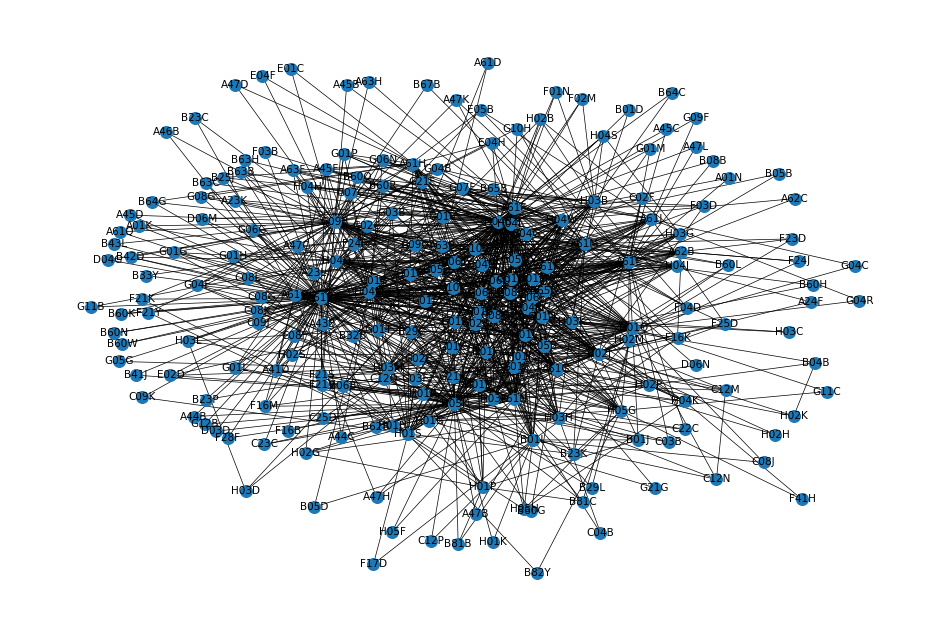

In [836]:
fig, axes = plt.subplots(1, 1, figsize = (12,8))

G_largest, pos = draw_graph(p2_graph)
nx.draw(G_largest, pos=pos, ax=axes, font_color='black', with_labels=True, font_size=7.5, width=0.5, node_size=70, edge_color='black')
plt.axis("off")
plt.show()

### Link Prediction Method
- Local measures

In [814]:
def cn(graph, ipc1, ipc2):
  return abs(len(list(nx.common_neighbors(graph, ipc1, ipc2))))

def jaccard(graph, ipc1, ipc2):
  ipc1_neighbors = list(graph.neighbors(ipc1))
  ipc2_neighbors = list(graph.neighbors(ipc2))
  sum_of_neighbors = abs(len(ipc1_neighbors) + len(ipc2_neighbors))
  common_of_neighbors = abs(len(list(nx.common_neighbors(graph, ipc1, ipc2))))
  if sum_of_neighbors == 0:
      return 0
  return common_of_neighbors / sum_of_neighbors
  
def pa(graph, ipc1, ipc2):
  ipc1_neighbors = len(list(graph.neighbors(ipc1)))
  ipc2_neighbors = len(list(graph.neighbors(ipc2)))
  return ipc1_neighbors * ipc2_neighbors

def aa(graph, ipc1, ipc2):
  s = 0
  for n in list(nx.common_neighbors(graph, ipc1, ipc2)):
    num_of_neighborhood = len(list(graph.neighbors(n)))
    s += 1 / math.log10(num_of_neighborhood)
  return s

def ra(graph, ipc1, ipc2):
  s = 0
  for n in list(nx.common_neighbors(graph, ipc1, ipc2)):
    num_of_neighborhood = len(list(graph.neighbors(n)))
    if num_of_neighborhood != 0:
      s += 1 / num_of_neighborhood
  return s
  
def hdi(graph, ipc1, ipc2):
  common_of_neighbors = abs(len(list(nx.common_neighbors(graph, ipc1, ipc2))))
  ipc1_neighbors = len(list(graph.neighbors(ipc1)))
  ipc2_neighbors = len(list(graph.neighbors(ipc2)))
  if ipc1_neighbors == 0 & ipc2_neighbors == 0:
    return 0
  elif ipc1_neighbors >= ipc2_neighbors:
    return common_of_neighbors / ipc1_neighbors
  else:
    return common_of_neighbors / ipc2_neighbors
  
def lhn_local(graph, ipc1, ipc2):
  common_of_neighbors = abs(len(list(nx.common_neighbors(graph, ipc1, ipc2))))
  ipc1_neighbors = len(list(graph.neighbors(ipc1)))
  ipc2_neighbors = len(list(graph.neighbors(ipc2)))
  if ipc1_neighbors == 0 or ipc2_neighbors == 0:
    return 0
  else:
    return common_of_neighbors / (ipc1_neighbors * ipc2_neighbors)

### Training

In [815]:
local_measures = [cn, jaccard, pa, aa, ra, hdi, lhn_local]

for measure in local_measures:
  train_df[measure.__name__] = [measure(p1_graph, ipc1, ipc2) for ipc1, ipc2 in train_df[["ipc1", "ipc2"]].values]

train_df

,ipc1,ipc2,train_y,cn,jaccard,pa,aa,ra,hdi,lhn_local
6,G09B,A61J,0,1,0.032258,58,1.285097,0.166667,0.034483,0.017241
8,G09B,A61M,0,5,0.106383,522,5.788389,0.687155,0.172414,0.009579
11,G09B,B01L,1,1,0.031250,87,1.047952,0.111111,0.034483,0.011494
12,G09B,B04B,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000
13,G09B,C12M,1,1,0.031250,87,1.047952,0.111111,0.034483,0.011494
...,...,...,...,...,...,...,...,...,...,...
373,H05K,C12M,1,0,0.000000,57,0.000000,0.000000,0.000000,0.000000
374,H05K,G01T,0,0,0.000000,76,0.000000,0.000000,0.000000,0.000000
375,H05K,G21G,1,0,0.000000,57,0.000000,0.000000,0.000000,0.000000
376,H05K,G2IK,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000


In [816]:
train_df.describe()

,train_y,cn,jaccard,pa,aa,ra,hdi,lhn_local
count,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000
mean,0.677524,0.540717,0.036305,29.592834,0.512988,0.048297,0.053560,0.019197
std,0.468187,0.963791,0.062092,57.240808,0.943712,0.095540,0.098367,0.043850
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.066667,33.000000,0.850274,0.066667,0.083333,0.019063
max,1.000000,5.000000,0.285714,522.000000,5.788389,0.687155,0.500000,0.333333


### test

In [817]:
local_measures = [cn, jaccard, pa, aa, ra, hdi, lhn_local]

for measure in local_measures:
  test_df[measure.__name__] = [measure(p2_graph, ipc1, ipc2) for ipc1, ipc2 in test_df[["ipc1", "ipc2"]].values]

test_df

,ipc1,ipc2,test_y,cn,jaccard,pa,aa,ra,hdi,lhn_local
11,G09B,B01L,0,12,0.114286,2156,10.333146,0.848673,0.155844,0.005566
12,G09B,B04B,1,0,0.000000,231,0.000000,0.000000,0.000000,0.000000
13,G09B,C12M,0,2,0.024390,385,1.480646,0.089669,0.025974,0.005195
15,G09B,G21G,0,0,0.000000,154,0.000000,0.000000,0.000000,0.000000
16,G09B,G2IK,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
362,H05K,A61D,1,2,0.026316,148,1.810527,0.157576,0.027027,0.013514
372,H05K,B04B,1,2,0.025974,222,1.903949,0.180556,0.027027,0.009009
373,H05K,C12M,0,4,0.050633,370,3.378358,0.266592,0.054054,0.010811
375,H05K,G21G,1,2,0.026316,148,1.756304,0.147619,0.027027,0.013514


In [818]:
test_df.describe()

,test_y,cn,jaccard,pa,aa,ra,hdi,lhn_local
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,0.788732,2.976526,0.059478,300.497653,2.422928,0.179901,0.092607,0.009562
std,0.409169,3.735906,0.062796,393.796646,3.096260,0.241320,0.106911,0.015296
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.037037,125.000000,0.960253,0.082492,0.043478,0.008746
75%,1.000000,5.000000,0.109589,464.000000,3.711206,0.268109,0.178571,0.013158
max,1.000000,17.000000,0.214286,2156.000000,14.439485,1.155821,0.391304,0.166667


### X_train, y_train, X_test, y_test

In [819]:
y_train = train_df.pop("train_y")
X_train = train_df
y_test = test_df.pop("test_y")
X_test = test_df

In [820]:
X_train

,ipc1,ipc2,cn,jaccard,pa,aa,ra,hdi,lhn_local
6,G09B,A61J,1,0.032258,58,1.285097,0.166667,0.034483,0.017241
8,G09B,A61M,5,0.106383,522,5.788389,0.687155,0.172414,0.009579
11,G09B,B01L,1,0.031250,87,1.047952,0.111111,0.034483,0.011494
12,G09B,B04B,0,0.000000,0,0.000000,0.000000,0.000000,0.000000
13,G09B,C12M,1,0.031250,87,1.047952,0.111111,0.034483,0.011494
...,...,...,...,...,...,...,...,...,...
373,H05K,C12M,0,0.000000,57,0.000000,0.000000,0.000000,0.000000
374,H05K,G01T,0,0.000000,76,0.000000,0.000000,0.000000,0.000000
375,H05K,G21G,0,0.000000,57,0.000000,0.000000,0.000000,0.000000
376,H05K,G2IK,0,0.000000,0,0.000000,0.000000,0.000000,0.000000


## Scaling

In [821]:
from sklearn import preprocessing

minmax_scaler = preprocessing.MinMaxScaler().fit(X_train.iloc[:, 2:])

In [822]:
X_train.iloc[:, 2:] = minmax_scaler.transform(X_train.iloc[:, 2:])
X_train

,ipc1,ipc2,cn,jaccard,pa,aa,ra,hdi,lhn_local
6,G09B,A61J,0.2,0.112903,0.111111,0.222013,0.242546,0.068966,0.051724
8,G09B,A61M,1.0,0.372340,1.000000,1.000000,1.000000,0.344828,0.028736
11,G09B,B01L,0.2,0.109375,0.166667,0.181044,0.161697,0.068966,0.034483
12,G09B,B04B,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13,G09B,C12M,0.2,0.109375,0.166667,0.181044,0.161697,0.068966,0.034483
...,...,...,...,...,...,...,...,...,...
373,H05K,C12M,0.0,0.000000,0.109195,0.000000,0.000000,0.000000,0.000000
374,H05K,G01T,0.0,0.000000,0.145594,0.000000,0.000000,0.000000,0.000000
375,H05K,G21G,0.0,0.000000,0.109195,0.000000,0.000000,0.000000,0.000000
376,H05K,G2IK,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [823]:
X_test.iloc[:, 2:] = minmax_scaler.transform(X_test.iloc[:, 2:])
X_test

,ipc1,ipc2,cn,jaccard,pa,aa,ra,hdi,lhn_local
11,G09B,B01L,2.4,0.400000,4.130268,1.785151,1.235053,0.311688,0.016698
12,G09B,B04B,0.0,0.000000,0.442529,0.000000,0.000000,0.000000,0.000000
13,G09B,C12M,0.4,0.085366,0.737548,0.255796,0.130492,0.051948,0.015584
15,G09B,G21G,0.0,0.000000,0.295019,0.000000,0.000000,0.000000,0.000000
16,G09B,G2IK,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
362,H05K,A61D,0.4,0.092105,0.283525,0.312786,0.229316,0.054054,0.040541
372,H05K,B04B,0.4,0.090909,0.425287,0.328926,0.262758,0.054054,0.027027
373,H05K,C12M,0.8,0.177215,0.708812,0.583644,0.387964,0.108108,0.032432
375,H05K,G21G,0.4,0.092105,0.283525,0.303418,0.214826,0.054054,0.040541


## 모델 학습
- 사용 모델 : Decision Tree, Logistic Regression, SVM, RF

In [837]:
train_input_features = X_train.iloc[:, 2:]
test_input_features = X_test.iloc[:, 2:]
result = pd.DataFrame(columns=["model", "accuraacy", "precision", "recall", "f1_score"])

In [838]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### DecisionTreeClassifier

In [839]:
dt_clf = DecisionTreeClassifier()

dt_params = {
  'max_depth' : [6, 8 ,10, 12, 16 ,20, 24],
  'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

dt_grid = GridSearchCV(dt_clf, param_grid=dt_params, scoring='accuracy', cv=5, verbose=1)
dt_grid.fit(train_input_features, y_train)

print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(dt_grid.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', dt_grid.best_params_)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
GridSearchCV 최고 평균 정확도 수치: 0.6875
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 6}


In [840]:
dt_model = dt_grid.best_estimator_
dt_pred = dt_model.predict(test_input_features)

acc_dt = accuracy_score(y_test, dt_pred)
pre_dt = precision_score(y_test, dt_pred)
rec_dt = recall_score(y_test, dt_pred)
f1_dt = f1_score(y_test, dt_pred)

print(f"accuraacy : {acc_dt}")
print(f"precision : {pre_dt}")
print(f"recall : {rec_dt}")
print(f"f1_score : {f1_dt}")

result.loc[0] = ["DecisionTreeClassifier", acc_dt, pre_dt, rec_dt, f1_dt]

accuraacy : 0.5117370892018779
precision : 0.9
recall : 0.42857142857142855
f1_score : 0.5806451612903225


### LogisticRegression

In [841]:
lr = LogisticRegression()

lr_params = {
  'solver':['liblinear', 'lbfgs'],
  'penalty':['l2', 'l1'],
  'C':[0.01, 0.1, 1, 1, 5, 10]
}

lr_grid = GridSearchCV(lr, param_grid=lr_params, scoring='accuracy', cv=5, verbose=1)
lr_grid.fit(train_input_features, y_train)

print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(lr_grid.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', lr_grid.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearchCV 최고 평균 정확도 수치: 0.7134
GridSearchCV 최적 하이퍼 파라미터: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


In [842]:
lr_model = lr_grid.best_estimator_
lr_pred = lr_model.predict(test_input_features)

acc_lr = accuracy_score(y_test, lr_pred)
pre_lr = precision_score(y_test, lr_pred)
rec_lr = recall_score(y_test, lr_pred)
f1_lr = f1_score(y_test, lr_pred)

print(f"accuraacy : {acc_lr}")
print(f"precision : {pre_lr}")
print(f"recall : {rec_lr}")
print(f"f1_score : {f1_lr}")

result.loc[1] = ["LogisticRegression", acc_lr, pre_lr, rec_lr, f1_lr]

accuraacy : 0.647887323943662
precision : 0.911504424778761
recall : 0.6130952380952381
f1_score : 0.7330960854092528


### RandomForestRegressor

In [843]:
rf = RandomForestClassifier(random_state=0)

rf_params = {
    'max_depth': [4, 8, 16, 24],
    'min_samples_leaf' : [1, 6, 12],
    'min_samples_split' : [2, 8, 16]
}

rf_grid = GridSearchCV(rf, param_grid=rf_params, scoring='accuracy', cv=5, verbose=1)
rf_grid.fit(train_input_features, y_train)

print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(rf_grid.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', rf_grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
GridSearchCV 최고 평균 정확도 수치: 0.7233
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 16}


In [844]:
rf_model = rf_grid.best_estimator_
rf_pred = rf_model.predict(test_input_features)

acc_rf = accuracy_score(y_test, rf_pred)
pre_rf = precision_score(y_test, rf_pred)
rec_rf = recall_score(y_test, rf_pred)
f1_rf = f1_score(y_test, rf_pred)

print(f"accuraacy : {acc_rf}")
print(f"precision : {pre_rf}")
print(f"recall : {rec_rf}")
print(f"f1_score : {f1_rf}")

result.loc[2] = ["RandomForestClassifier", acc_rf, pre_rf, rec_rf, f1_rf]

accuraacy : 0.48826291079812206
precision : 0.9041095890410958
recall : 0.39285714285714285
f1_score : 0.5477178423236514


### SVM

In [845]:
svc = SVC(random_state=0)

svc_params = {
  'C' : [0.001, 0.01, 0.1, 1, 10, 100],
  'gamma' : [0.0005, 0.001, 0.01, 0.1, 1, 10, 100]
}

svc_grid = GridSearchCV(svc, param_grid=svc_params, scoring='accuracy', cv=5, verbose=1)
svc_grid.fit(train_input_features, y_train)

print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(svc_grid.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', svc_grid.best_params_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
GridSearchCV 최고 평균 정확도 수치: 0.7134
GridSearchCV 최적 하이퍼 파라미터: {'C': 1, 'gamma': 1}


In [846]:
svc_model = svc_grid.best_estimator_
svc_pred = svc_model.predict(test_input_features)

acc_svc = accuracy_score(y_test, svc_pred)
pre_svc = precision_score(y_test, svc_pred)
rec_svc = recall_score(y_test, svc_pred)
f1_svc = f1_score(y_test, svc_pred)

print(f"accuraacy : {acc_svc}")
print(f"precision : {pre_svc}")
print(f"recall : {rec_svc}")
print(f"f1_score : {f1_svc}")

result.loc[3] = ["SVM", acc_svc, pre_svc, rec_svc, f1_svc]

accuraacy : 0.647887323943662
precision : 0.9043478260869565
recall : 0.6190476190476191
f1_score : 0.734982332155477


## 모델 결과

In [847]:
result

,model,accuraacy,precision,recall,f1_score
0,DecisionTreeClassifier,0.511737,0.900000,0.428571,0.580645
1,LogisticRegression,0.647887,0.911504,0.613095,0.733096
2,RandomForestClassifier,0.488263,0.904110,0.392857,0.547718
3,SVM,0.647887,0.904348,0.619048,0.734982
